In [18]:
from dotenv import load_dotenv
from agents import Agent, Runner, trace, function_tool
from openai.types.responses import ResponseTextDeltaEvent
from typing import Dict
import sendgrid
import os
import asyncio
from dotenv import load_dotenv
from agents import Agent, Runner, trace, function_tool
from openai.types.responses import ResponseTextDeltaEvent
from typing import Dict
import sendgrid
import os
from sendgrid.helpers.mail import Mail, Email, To, Content
import asyncio



In [19]:
load_dotenv(override=True)

True

In [20]:

junior_agent = Agent(
    name="Junior Candidate",
    instructions="You are a junior job applicant. Write a simple, polite job application email highlighting eagerness to learn and basic skills.",
    model="gpt-4o-mini"
)

mid_agent = Agent(
    name="Mid-level Candidate",
    instructions="You are a mid-level job applicant. Write a professional job application email emphasizing relevant experience and teamwork.",
    model="gpt-4o-mini"
)

senior_agent = Agent(
    name="Senior Candidate",
    instructions="You are a senior job applicant. Write a persuasive job application email showcasing leadership, achievements, and vision.",
    model="gpt-4o-mini"
)


In [21]:
# Tool’a dönüştürme
tool_junior = junior_agent.as_tool(
    tool_name="junior_candidate",
    tool_description="Write a simple job application email as a junior candidate"
)

tool_mid = mid_agent.as_tool(
    tool_name="mid_candidate",
    tool_description="Write a professional job application email as a mid-level candidate"
)

tool_senior = senior_agent.as_tool(
    tool_name="senior_candidate",
    tool_description="Write an impressive job application email as a senior/experienced candidate"
)

candidate_tools = [tool_junior, tool_mid, tool_senior]


In [22]:
description_junior = "Write a concise and enthusiastic job application email for an entry-level position. " \
                                        "Highlight eagerness to learn, relevant academic projects or internships," \
                                        "and a strong foundational understanding of the field."

description_mid = "Write a professional and results-oriented job application email for a mid-level role. " \
                                    "Focus on past accomplishments, specific metrics (e.g., 'increased efficiency by 15%'), " \
                                    "and how their skills align with the job requirements. Emphasize a proactive and collaborative work style."

description_senior = "Write a commanding and strategic job application email for a senior leadership or expert role. " \
                                        "The email should demonstrate a deep understanding of the industry, a history of leading successful initiatives," \
                                        "and a vision for future contributions. Frame the application as a strategic partnership rather than a simple job request."

In [23]:
junior_agent = junior_agent.as_tool(tool_name="junior_candidate", tool_description=description_junior)
mid_agent = mid_agent.as_tool(tool_name="mid_candidate", tool_description=description_mid)
senior_agent = senior_agent.as_tool(tool_name="senior_candidate", tool_description=description_senior)


In [24]:
candidate_tools = [junior_agent, mid_agent, senior_agent]

In [25]:
candidate_tools

[FunctionTool(name='junior_candidate', description='Write a concise and enthusiastic job application email for an entry-level position. Highlight eagerness to learn, relevant academic projects or internships,and a strong foundational understanding of the field.', params_json_schema={'properties': {'input': {'title': 'Input', 'type': 'string'}}, 'required': ['input'], 'title': 'junior_candidate_args', 'type': 'object', 'additionalProperties': False}, on_invoke_tool=<function function_tool.<locals>._create_function_tool.<locals>._on_invoke_tool at 0x74dfbbf9be20>, strict_json_schema=True, is_enabled=True),
 FunctionTool(name='mid_candidate', description="Write a professional and results-oriented job application email for a mid-level role. Focus on past accomplishments, specific metrics (e.g., 'increased efficiency by 15%'), and how their skills align with the job requirements. Emphasize a proactive and collaborative work style.", params_json_schema={'properties': {'input': {'title': 'Inp

In [26]:
subject_instructions = """
You can write a subject for a job application email.
You are given a message and you need to write a subject line that will catch the HR manager's attention.
"""


In [27]:
subject_writer = Agent(
    name="Job Application Subject Writer",
    instructions=subject_instructions,
    model="gpt-4o-mini"
)
subject_tool = subject_writer.as_tool(
    tool_name="subject_writer",
    tool_description="Write a subject for a job application email"
)

In [28]:
html_instructions = """
You can convert a text email body to an HTML job application email body.
You are given a plain text email (may contain markdown) and need to convert it into an HTML email with a clean, professional layout.
"""

html_converter = Agent(
    name="HTML Email Body Converter",
    instructions=html_instructions,
    model="gpt-4o-mini"
)
html_tool = html_converter.as_tool(
    tool_name="html_converter",
    tool_description="Convert a text job application email to HTML format"
)


In [29]:
email_formatter_instructions = """
You are an email formatter and sender for job applications.
You first use the subject_writer tool to write a subject for the email, 
then use the html_converter tool to convert the email body to HTML, 
and finally use the send_html_email tool to send the email with the subject and HTML body.
"""

In [30]:
emailer_agent = Agent(
    name="Job Application Email Manager",
    instructions=email_formatter_instructions,
    tools=[subject_tool, html_tool],
    model="gpt-4o-mini",
    handoff_description="Convert a job application email to HTML and send it"
)

In [31]:
hr_manager_instructions = """
You are a discerning HR Manager tasked with finding the perfect candidate for a role. 
Your job is to select the single most compelling and appropriate application email from the three candidates (junior, mid-level, senior).
Evaluate the applications based on their strategic fit for the role, the candidate's demonstrated impact, and the overall quality of communication.
Your final selection should be the one that is most likely to secure an interview.
"""

In [32]:
hr_manager = Agent(
    name="HR Manager",
    instructions=hr_manager_instructions,
    tools=candidate_tools,
    handoffs=[emailer_agent],
    model="gpt-4o-mini"
)

In [33]:
message = "Prepare a job application email addressed to 'Dear Hiring Manager' from John Doe"

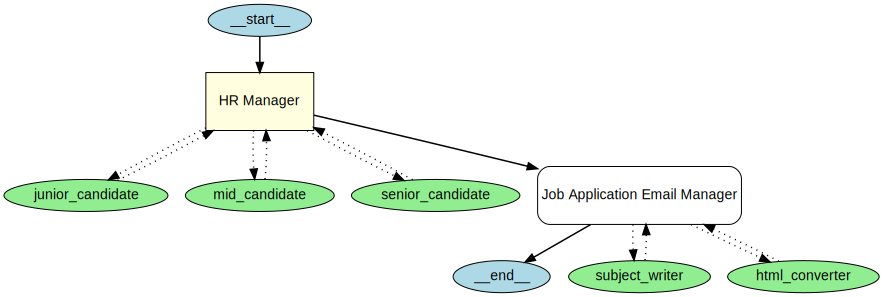

In [34]:
with trace("Automated Job Application Process"):
    result = await Runner.run(hr_manager, message)

from agents.extensions.visualization import draw_graph
draw_graph(hr_manager)